##### 1. copy conversion functions:
###### - interpolated blm calibration curve and r5im, with integration:
###### - - volts to protons
###### - - coulombs to joules
##### 2. attributes for functions
##### 3. ready to modulate
##### 4. replace integer values with variables
##### 5. work on returns with hen

In [143]:
import glob
import pandas as pd
import paho.mqtt.client as mqtt
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import integrate
from scipy.constants import c, m_p, e
import DataFilterModule as dfm

##### csv - make into module

In [154]:
class ImportData:
    def __init__(self):
        index = 0
        folder = None
        cycle = True
    
    def fetch(self, index=0, folder=None, cycle=True) -> None:
        if folder is None:
            if cycle:
                folder = './BLM_R5IM_Data/cycle/'
            else:
                folder = './BLM_R5IM_Data/R5IM_loss/'
    
        if folder[-1] != '/': folder += '/'        
        
        input_data = pd.read_csv(glob.glob(folder + '*.csv')[index])
        return input_data.drop(columns = input_data.columns[0]).to_numpy()
    
# csv = ImportData()
# y = csv.fetch()

##### mqtt - make into module

In [121]:
def generate_shortuuid() -> str:
    """Public function for generating short UUID messages"""
    alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits
    shortuiid = "".join(random.choices(alphabet, k=12))
    return shortuiid

class MQTTClient(mqtt.Client):
    def __init__(self, topic_name, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.topic_name = topic_name

    def on_connect(self, client, userdata, flags, rc):
        print('Connected to: ' + str(self.topic_name))
        self.subscribe(self.topic_name)

    def on_disconnect(self, client, userdata, rc):
        print('Disconnected from: ' + str(self.topic_name))
        
    def on_message(self, client, userdata, message):
        msg_byte = message.payload
        msg_decode = np.frombuffer(msg_byte, dtype=float, count=-1, offset=0)
        msg_array = np.reshape(msg_decode, (40, 2200))
        print(msg_array)

def get_live_data(topic_name, time_period):
    client = MQTTClient(topic_name)
    client.connect("130.246.57.45", 8883, 60)
    client.loop_start()
    time.sleep(time_period)
    client.disconnect()
    client.loop_stop()
        
get_live_data("ac_phys/workxp/live_signals", 5)

Connected to: ac_phys/workxp/live_signals
Disconnected from: ac_phys/workxp/live_signals


##### filtering - make into module

In [120]:
class DataFilter:

  labels = ["r0blm1", "r0blm3", "r0blm4",
            "r1blm1", "r1blm2", "r1blm3", "r1blm4",
            "r2blm1", "r2blm2", "r2blm3", "r2blm4",
            "r3blm1", "r3blm2", "r3blm3", "r3blm4",
            "r4blm1", "r4blm2", "r4blm3", "r4blm4",
            "r5blm1", "r5blm2", "r5blm3", "r5blm4",
            "r6blm1", "r6blm2", "r6blm3", "r6blm4",
            "r7blm1", "r7blm2", "r7blm3", "r7blm4",
            "r8blm1", "r8blm2", "r8blm3", "r8blm4",
            "r9blm1", "r9blm2", "r9blm3", "r9blm4",
            "r5im"]

    def __init__(self, *, select = True, invert = False, scale = 1, offset = 0, auto_offset = 0):
    '''Creates a filterer object, with configurable settings to filter input data.
    '''

    self.data = []

    template = {
      "select": select,
      "invert": invert,
      "scale": scale,
      "offset": offset,
      "auto_offset": auto_offset,
    }

    self.settings = [deepcopy(template) for i in range(40)]

    def set(self, setting: str, state, labels: list[str | int] = None) -> None:
    if labels is None:
      for each in self.settings:
        each[setting] = state
    
    else:
      # single specified
      if isinstance(labels, str) or isinstance(labels, int):
        self.settings[self._index_(labels)][setting] = state

      # multiple specified
      else:
        for each in labels:
          self.settings[self._index_(each)][setting] = state

  
  def reset(self) -> None:
    '''Resets filters to their default settings.'''

    self.settings = [{
      "select": True,
      "invert": False,
      "scale": 1,
      "offset": 0,
      "auto_offset": 0
    }] * 40
    
# filterer = dfm.DataFilter()
# filterer.set("invert", True, "r5im")
# filterer.apply(y)

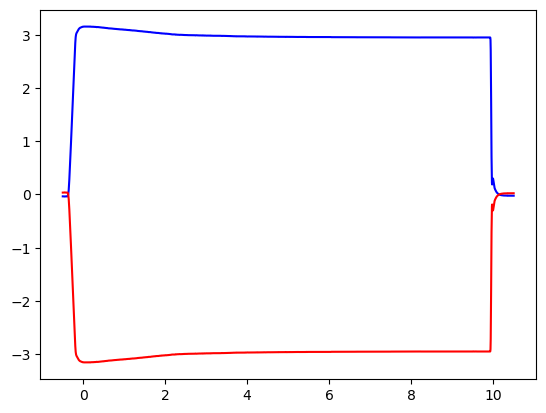

In [132]:
plt.plot(x_data, y[39], 'b')

filterer = dfm.DataFilter()

filterer.set("invert", True, "r5im")
filterer.apply(y)

plt.plot(x_data, y[39], 'r')

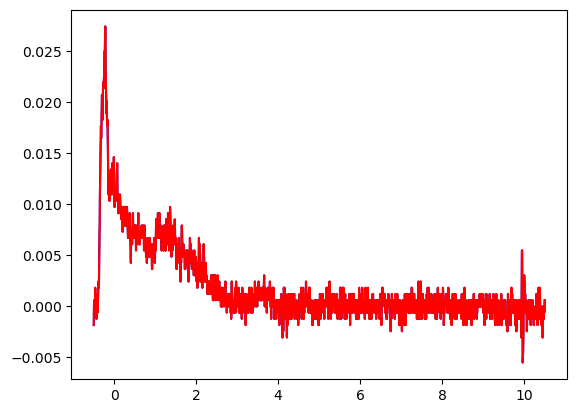

In [113]:
plt.plot(x_data, y[1], 'b')

filterer2 = dfm.DataFilter()

filterer2.set("auto_offset", 10)
filterer2.apply(y)

plt.plot(x_data, y[1], 'r')

##### time interval - make into module

In [66]:
def setTimeInterval(array, start, end, step):
    for i in range(start - 1, end):
        yNewRange.append(oldArray[i])
    for i in yNewRange[::step]:
        yNewRangeStepped.append(i)
        print(yNewRangeStepped)

##### conversion - make into module

In [ ]:
class Convert:
    def toMomentum(maxE, time):
        mpeV = m_p * c**2 / e           # Proton mass in eV
        R0 = 26                         # Mean machine radius
        nDip = 10                      # Number of dipoles
        dipl = 4.4                     # Dipole length
    
        dipAngle = 2 * np.pi / n_dip   # Dipole bending angle
        rho = dipl / dipAngle         # Dipole radius of curvature
        omega = 2 * np.pi * 50   
    
        Ek = np.array([70, maxE]) * 1e6 # Injection and extraction kinetic energies 
        E = Ek + mpeV                    # Injection and extraction kinetic energies
        p = np.sqrt(E**2 - mpeV**2)      # Injection and extraction momenta

        B = p / c / rho                  # Ideal magnetic field at injection and extraction energies
    
        Bdip = lambda t: (B[1] + B[0] - (B[1] - B[0]) * np.cos(omega * t)) / 2  # Idealised B-field variation with AC
        pdip = lambda t: Bdip(t) * rho * c                                      # Momentum from B-field in MeV
    
        return pdip(time*1E-3)

    def toKE(maxE, time):
        mpeV = m_p * c**2 / e           # Proton mass in eV    
        # Relativistic Kinetic Energy = Relativistic Energy - mass
        return (np.sqrt(toMomentum(max_E, time)**2 + mpeV**2) - mpeV) # Return array in eV
        #return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV)/1E6 # Return array in MeV
        
    def integrate(maxE, start, stop):
        # np linspace array of the energy ramp of the beam between -0.5 and 10.5 ms with 2200 points
        energyRamp = (toKE(maxE, (np.linspace(-0.5, 10.5, 2200, endpoint = True))))[start:stop]
        
        # energy_ramp = (((E_max-70)/2*(np.sin(np.linspace(-0.5, 10.5, 2200)*(np.pi/10)-(np.pi/2))))+(E_max-70)/2+70)[start:stop]
        # chris' data
        chrisX = [0, 3, 5, 7, 9]
        chrisY = [2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14]
        
        # chris' calibration curve interpolated over a linspace of 2200 points between -0.5 and 10.5
        chrisCalibration = np.interp(np.linspace(-0.5, 10.5, 2200), chrisX, chrisY)
        
        timeArray = np.linspace(-0.5, 10.5, len(chrisCalibration))
        
        # chris' calibration curve interpolated in protons/V s
        finalCalibration = 1/chrisCalibration
        data = fetch(0, None, False)[1:38]
        
        # relevant calibration curve between start and stop time periods
        # The calibration constant before 0 seconds should be zero - as the losses from the BLMs should be discounted during this period
        # final_calibration[0:find_nearest(np.linspace(-0.5, 10.5, num=2200), 0)] = 0
        calibrationCurve = finalCalibration[start:stop]
        blmSum = np.sum(data, axis = 0)
        
        # sum_1 gives the relevant blm sum signal as an array betwen the start and stop time periods 
        sum1 = blmSum[start:stop]
        
        # cumulative_sum sums the trapezoids cumulatively in an increasing array. 
        # we need to find the difference between consecutive values to find the integrals of each bin
        cumulativeSum = integrate.cumulative_trapezoid(sum1, x = np.linspace(-0.5, 10.5, 2200)[start:stop])
           
        # integrated_sum is an array of all integrated bins between start and stop
        integratedSum = [0]
        integratedSum[0] = cumulativeSum[0]
        for i in range(1, len(cumulativeSum)):
            integratedSum.append((cumulativeSum[i]-cumulativeSum[i-1]))
            
        # remember to change from s to ms
        integratedSum = [i * 1000 for i in integratedSum]
        
        # integrated bins in Vms divided by 1000 to get Vs and multiplying by calibration constants to get number of protons
        
        
        # print(len(protons))
        
        
        protons_per_bin = ((np.array(integrated_sum))*0.001*(np.delete(calibration_curve, [0])))